In [1]:
%matplotlib inline

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helper import tool_palette, tool_text_styling_dict

plt.style.use("./paper.mplstyle")

In [2]:
tbl = biom.load_table("../results/batch/sim/sim_counts.biom")
tbl

10 x 300 <class 'biom.table.Table'> with 1873 nonzero entries (62% dense)

In [3]:
md = pd.read_table("../results/batch/sim/metadata.tsv", sep="\t", index_col=0)
md["batch"] = "B" + md["batch"].astype(str)
batch_categories = sorted(md["batch"].unique(), key=lambda x: int(x[1:]))
md["batch"] = pd.Categorical(md["batch"], categories=batch_categories, ordered=True)
md.index = tbl.ids()
md

,intercept,case_ctrl,log_depth,batch
SA1,1,0,8.350902,B5
SA2,1,0,8.800867,B6
SA3,1,0,8.452761,B10
SA4,1,0,8.293049,B10
SA5,1,0,8.574707,B10
...,...,...,...,...
SB146,1,1,8.381144,B3
SB147,1,1,8.535230,B1
SB148,1,1,8.715224,B5
SB149,1,1,8.770439,B9


In [4]:
md["batch"].value_counts()

B4     36
B2     35
B5     34
B6     33
B1     33
B10    30
B9     28
B3     26
B7     25
B8     20
Name: batch, dtype: int64

In [5]:
from gemelli.rpca import rpca

ord_res, dm = rpca(tbl, n_components=3)

/home/grahman/miniconda3/envs/birdman-analyses-final/lib/python3.8/site-packages/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


In [6]:
samp_axes = ord_res.samples.join(md)
samp_axes["case_ctrl"] = samp_axes["case_ctrl"].map({0: "Case", 1: "Control"})
samp_axes = samp_axes.rename(columns={"case_ctrl": "Sample Type", "batch": "Batch"})
samp_axes.head()

,PC1,PC2,PC3,intercept,Sample Type,log_depth,Batch
SA1,-0.009788,0.015752,0.018853,1,Case,8.350902,B5
SA2,-0.053762,-0.026134,-0.008805,1,Case,8.800867,B6
SA3,0.058020,-0.025247,0.004849,1,Case,8.452761,B10
SA4,0.046023,-0.017371,0.013107,1,Case,8.293049,B10
SA5,0.014683,0.000769,0.024495,1,Case,8.574707,B10


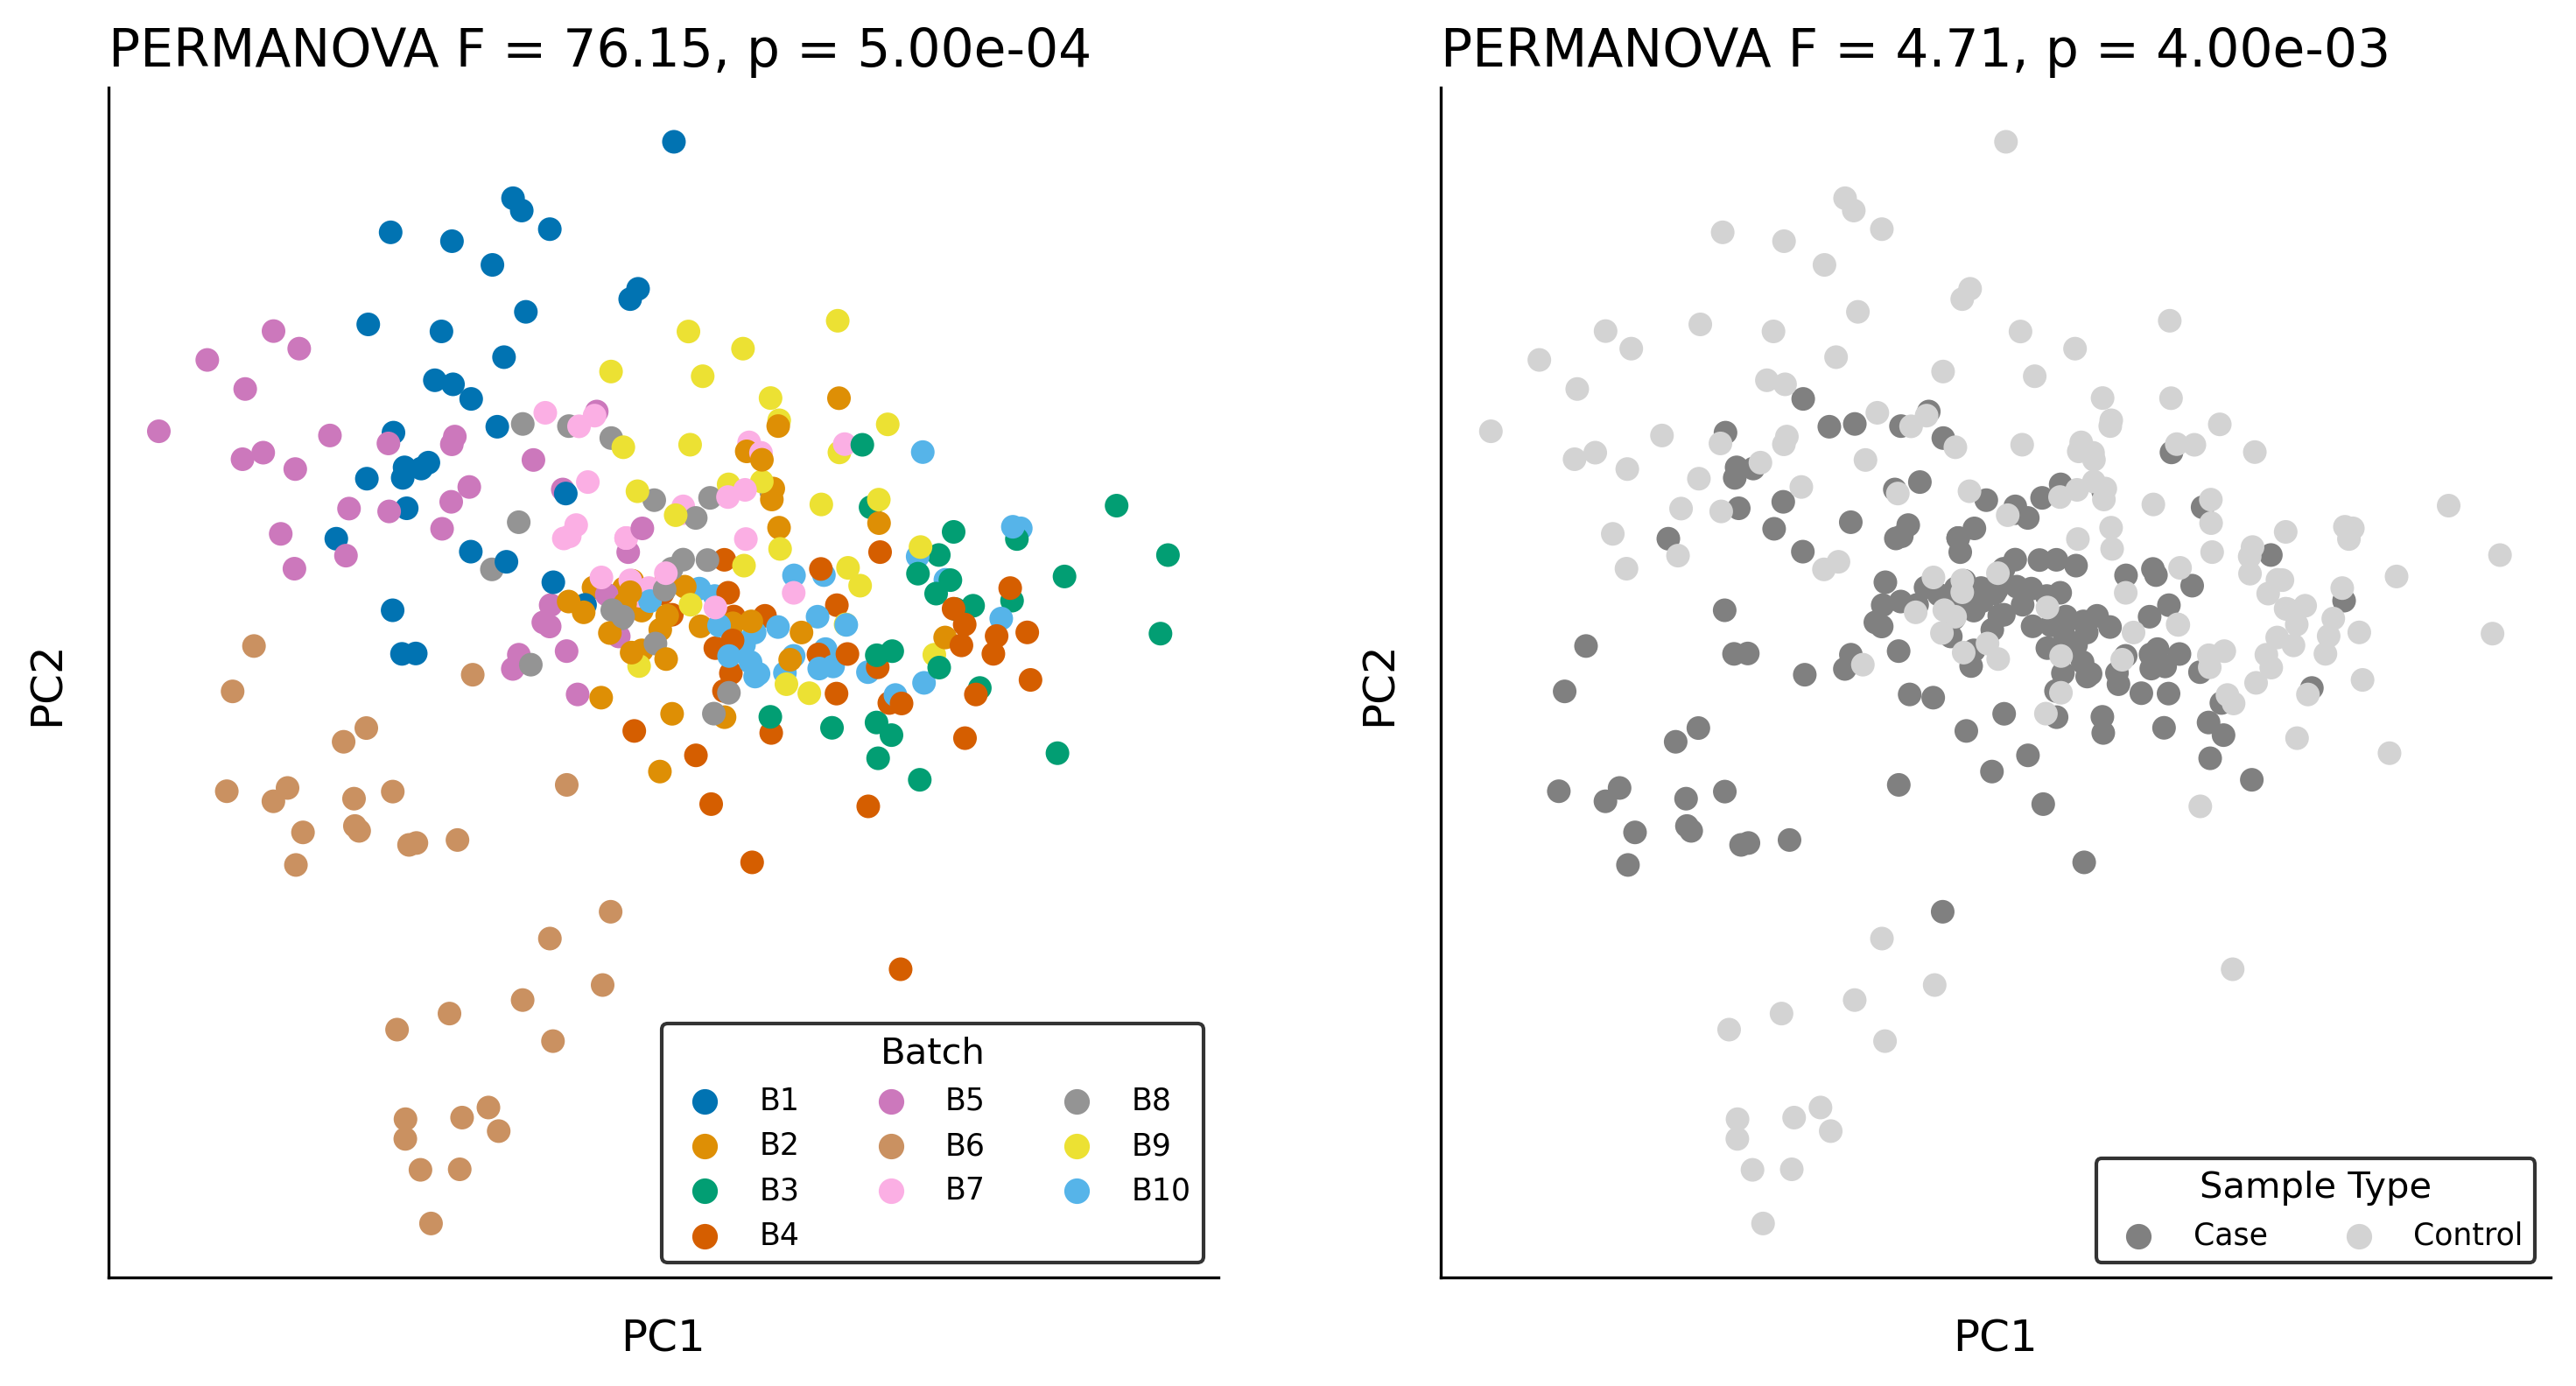

In [7]:
from skbio.stats.distance import permanova

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

cats = batch_categories
pal = dict(zip(cats, sns.color_palette("colorblind", len(cats))))
pal["Control"] = "lightgray"
pal["Case"] = "gray"

prop_exp = ord_res.proportion_explained

for ax, var in zip([ax1, ax2], ["Batch", "Sample Type"]):
    sns.scatterplot(
        data=samp_axes,
        x="PC1",
        y="PC2",
        hue=var,
        edgecolor=None,
        palette=pal,
        ax=ax
    )

    pnova_res = permanova(dm, samp_axes, var, permutations=2000)
    F = pnova_res["test statistic"]
    p = pnova_res["p-value"]
    ax.set_title(
        f"PERMANOVA F = {F:.2f}, p = {p:.2e}",
    )

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles=handles,
        ncol=3,
        title=var,
        loc="lower right",
        fontsize="small",
        edgecolor="black"
    )

for ax in (ax1, ax2):
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params("both", width=0)

plt.show()

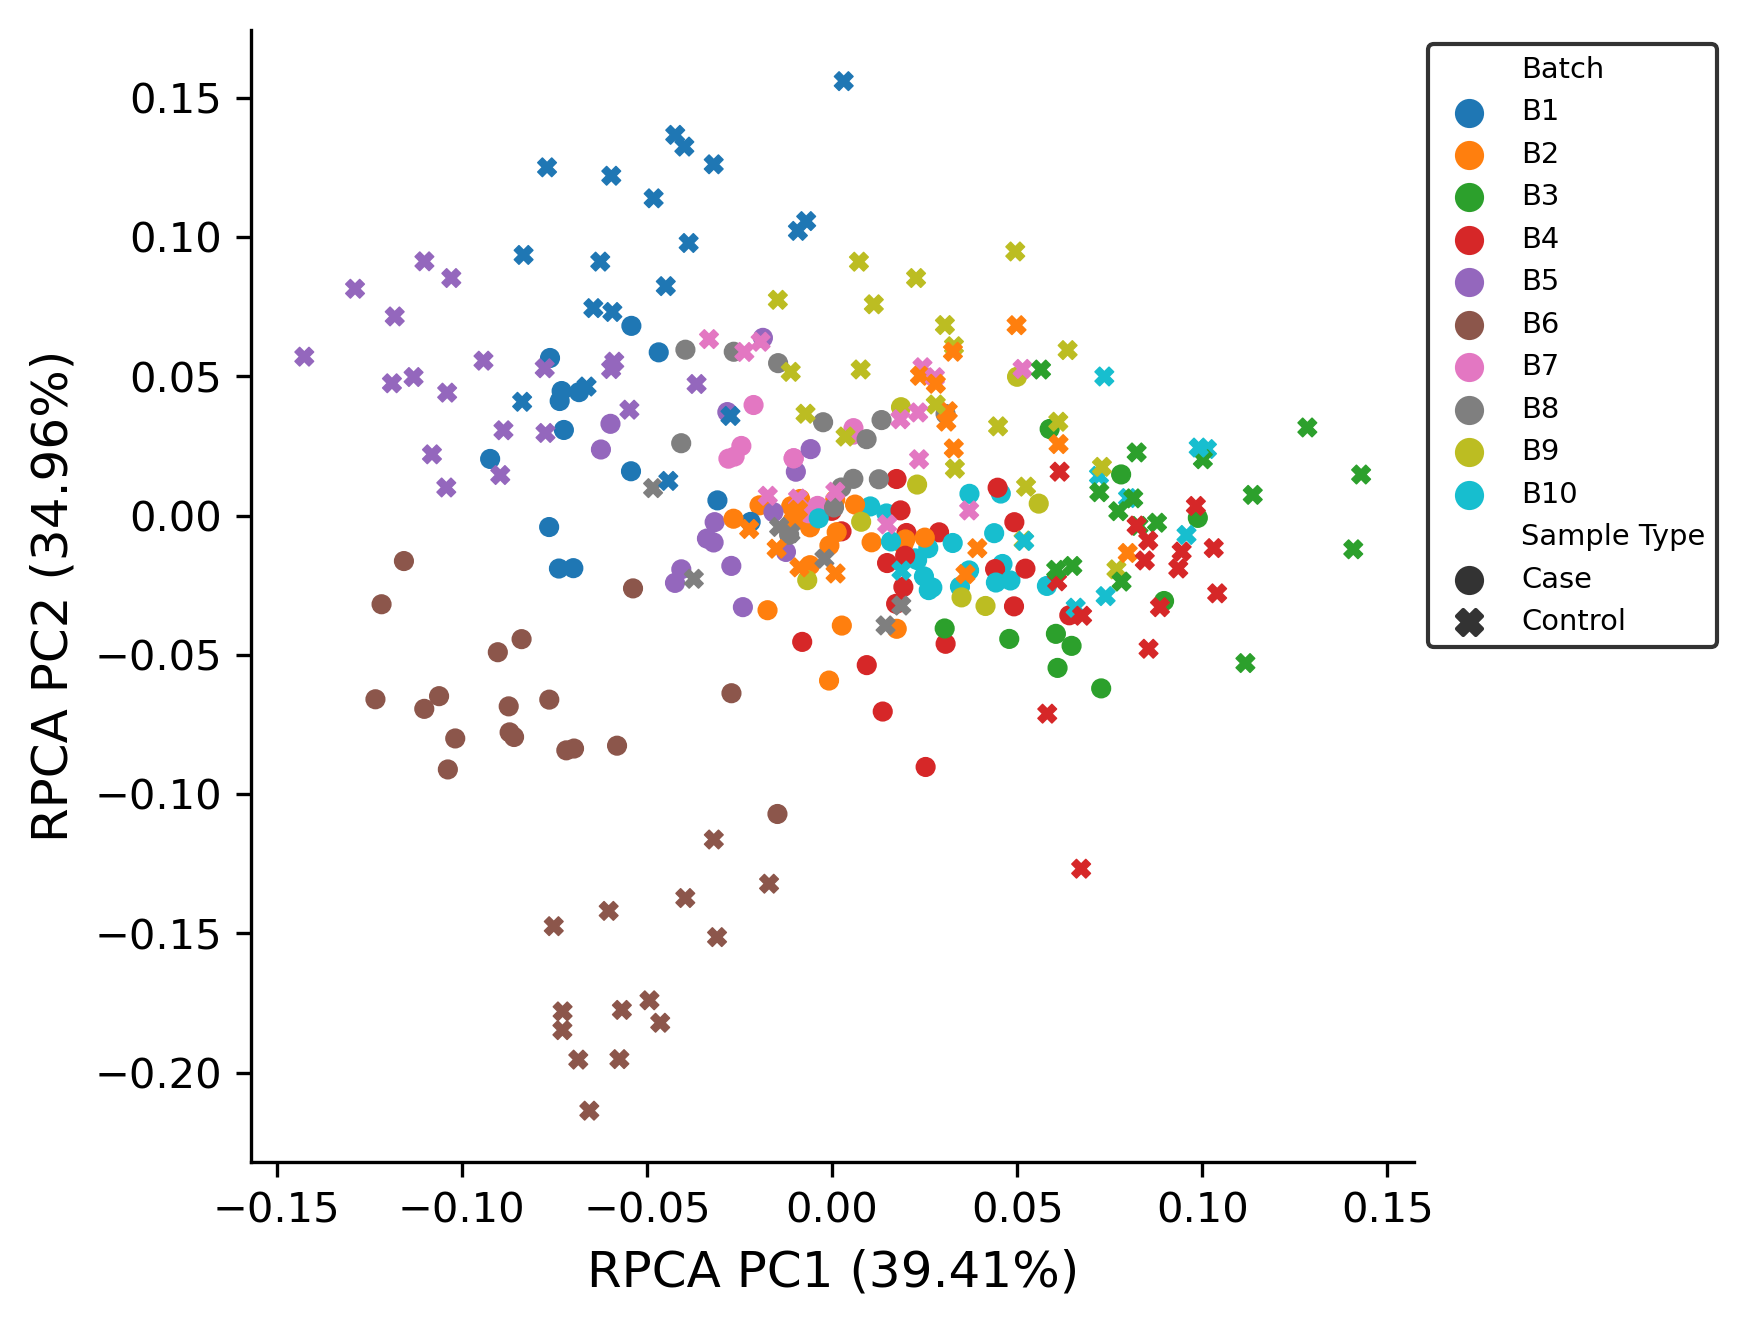

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    data=samp_axes,
    x="PC1",
    y="PC2",
    ax=ax,
    style="Sample Type",
    edgecolor=None,
    s=20,
    hue="Batch",
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    loc="upper left",
    bbox_to_anchor=[1, 1],
    edgecolor="black"
)

pc_var = prop_exp * 100
ax.set_xlabel(f"RPCA PC1 ({pc_var[0]:.2f}%)")
ax.set_ylabel(f"RPCA PC2 ({pc_var[1]:.2f}%)")

plt.savefig("../figures/simulation/batch_permanova.pdf")
plt.show()

In [9]:
import arviz as az

inf = az.from_netcdf("../results/batch/regression_inf.nc")

In [10]:
inf.posterior

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 500, feature: 10, batch: 10, covariate: 2)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * batch          (batch) int64 1 2 3 4 5 6 7 8 9 10
  * covariate      (covariate) object 'Intercept' 'C(case_ctrl, Treatment(0))...
  * feature        (feature) object 'F1' 'F2' 'F3' 'F4' ... 'F7' 'F8' 'F9' 'F10'
Data variables:
    inv_disp       (feature, chain, draw) float64 ...
    batch_disps    (feature, chain, draw, batch) float64 ...
    batch_offsets  (feature, chain, draw, batch) float64 ...
    beta_var       (feature, chain, draw, covariate) float64 ...
Attributes:
    created_at:                 2022-08-03T20:43:05.368071
    arviz_version:              0.12.1
    inference_library:          cmdstanpy
    inference_library_version:  1.0.4

In [11]:
import json

with open("../results/batch/sim/params.json", "r") as f:
    params = json.load(f)
    
params.keys()

dict_keys(['N', 'log_depths', 'D', 'beta_0', 'beta_1', 'inv_disp', 'num_batches', 'batch_map', 'batch_offsets', 'batch_disps'])

In [12]:
params["beta_1"]

[-0.20340833419348847,
 2.9087096246355473,
 2.6498364884822694,
 0.8782927117888131,
 2.232711977121152,
 2.699030025403416,
 2.981043808797338,
 2.3348345528338292,
 3.236729633274903,
 2.6530467676598186]

In [13]:
feat_names = inf.posterior.coords["feature"].values
true_vals = pd.Series(params["beta_1"]).rename("true_beta_1")
true_vals.index = feat_names

In [14]:
true_vals

F1    -0.203408
F2     2.908710
F3     2.649836
F4     0.878293
F5     2.232712
F6     2.699030
F7     2.981044
F8     2.334835
F9     3.236730
F10    2.653047
Name: true_beta_1, dtype: float64

In [15]:
quantile_df = (
    inf.posterior
    .stack(sample=["chain", "draw"])
    .sel({"covariate": "C(case_ctrl, Treatment(0))[T.1]"})
    ["beta_var"]
    .quantile([0.005, 0.025, 0.25, 0.5, 0.75, 0.975, 0.995], ["sample"])
    .to_pandas()
    .T
)
quantile_df.head()

quantile,0.005,0.025,0.250,0.500,0.750,0.975,0.995
feature,,,,,,,
F1,-0.463520,-0.398272,-0.225935,-0.134442,-0.049538,0.114779,0.232915
F2,2.470818,2.555606,2.764955,2.879645,3.001655,3.218668,3.302685
F3,2.440127,2.499645,2.616955,2.676895,2.737683,2.852698,2.906360
F4,0.437999,0.525473,0.715015,0.808961,0.905754,1.098150,1.190840
F5,1.836115,1.946683,2.158990,2.274505,2.382257,2.599011,2.707721


In [16]:
aldex2_results = (
    pd.read_table("../results/batch/aldex2_results.tsv", sep="\t", index_col=0)
    [["model.case_ctrl1 Estimate", "model.case_ctrl1 Pr(>|t|).BH"]]
    .set_axis(["aldex2_beta", "aldex2_qval"], axis=1)
)
aldex2_results.head()

,aldex2_beta,aldex2_qval
F1,-3.223754,2.472868e-10
F2,0.616714,5.176894e-01
F3,1.267658,3.214014e-02
F4,-1.978653,1.686390e-03
F5,-0.739782,4.963014e-01


In [17]:
deseq2_results = (
    pd.read_table("../results/batch/deseq2_results.tsv", sep="\t", index_col=0)
    [["log2FoldChange", "padj"]]
    .set_axis(["deseq2_beta", "deseq2_qval"], axis=1)
)
# Convert log2 -> nl
deseq2_results["deseq2_beta"] = deseq2_results["deseq2_beta"].apply(lambda x: x / np.log2(np.e))
deseq2_results.head()

,deseq2_beta,deseq2_qval
F1,-1.748180,2.699086e-05
F2,1.413097,3.468497e-07
F3,1.625056,1.544251e-14
F4,-0.836107,4.240670e-03
F5,0.956714,4.340220e-04


In [18]:
ancombc_results = (
    pd.read_table("../results/batch/ancombc_results.tsv", sep="\t", index_col=0)
    [["case_ctrl1_beta", "case_ctrl1_qval"]]
    .set_axis(["ancombc_beta", "ancombc_qval"], axis=1)
)
ancombc_results.head()

,ancombc_beta,ancombc_qval
F1,-1.625168,1.103943e-39
F2,0.097997,1.000000e+00
F3,0.668385,1.534044e-03
F4,-0.929128,1.575243e-04
F5,-0.306919,4.967914e-01


In [19]:
birdman_beta = (
    inf.posterior
    ["beta_var"]
    .sel({"covariate": "C(case_ctrl, Treatment(0))[T.1]"})
    .mean(["chain", "draw"])
    .to_pandas()
    .rename("birdman_beta")
)

In [20]:
results_df = pd.concat(
    [birdman_beta, ancombc_results, deseq2_results, aldex2_results, true_vals],
    axis=1
)
results_df.head()

,birdman_beta,ancombc_beta,ancombc_qval,deseq2_beta,deseq2_qval,aldex2_beta,aldex2_qval,true_beta_1
feature,,,,,,,,
F1,-0.138286,-1.625168,1.103943e-39,-1.748180,2.699086e-05,-3.223754,2.472868e-10,-0.203408
F2,2.882047,0.097997,1.000000e+00,1.413097,3.468497e-07,0.616714,5.176894e-01,2.908710
F3,2.677059,0.668385,1.534044e-03,1.625056,1.544251e-14,1.267658,3.214014e-02,2.649836
F4,0.811859,-0.929128,1.575243e-04,-0.836107,4.240670e-03,-1.978653,1.686390e-03,0.878293
F5,2.271056,-0.306919,4.967914e-01,0.956714,4.340220e-04,-0.739782,4.963014e-01,2.232712


In [21]:
from sklearn.metrics import mean_squared_error, explained_variance_score

def evaluate_tool_rmse(col):
    return mean_squared_error(results_df["true_beta_1"], col, squared=False)

order = ["BIRDMAn", "DESeq2", "ALDEx2", "ANCOM-BC"]

tool_rmses = (
    results_df
    .filter(like="beta")
    .drop(columns=["true_beta_1"])
    .apply(evaluate_tool_rmse, axis=0)
    .sort_values()
    .to_frame()
    .set_axis(["RMSE"], axis=1)
    .reset_index()
    .assign(Tool=lambda x: x["index"].str.extract("(\w*)_beta"))
    .assign(Tool=lambda x: x["Tool"].map(tool_text_styling_dict))
)

tool_rmses["Tool"] = pd.Categorical(tool_rmses["Tool"], categories=order, ordered=True)
tool_rmses = tool_rmses.sort_values(by="Tool").reset_index(drop=True)
tool_rmses

,index,RMSE,Tool
0,birdman_beta,0.064017,BIRDMAn
1,deseq2_beta,1.308105,DESeq2
2,aldex2_beta,2.351853,ALDEx2
3,ancombc_beta,2.294558,ANCOM-BC


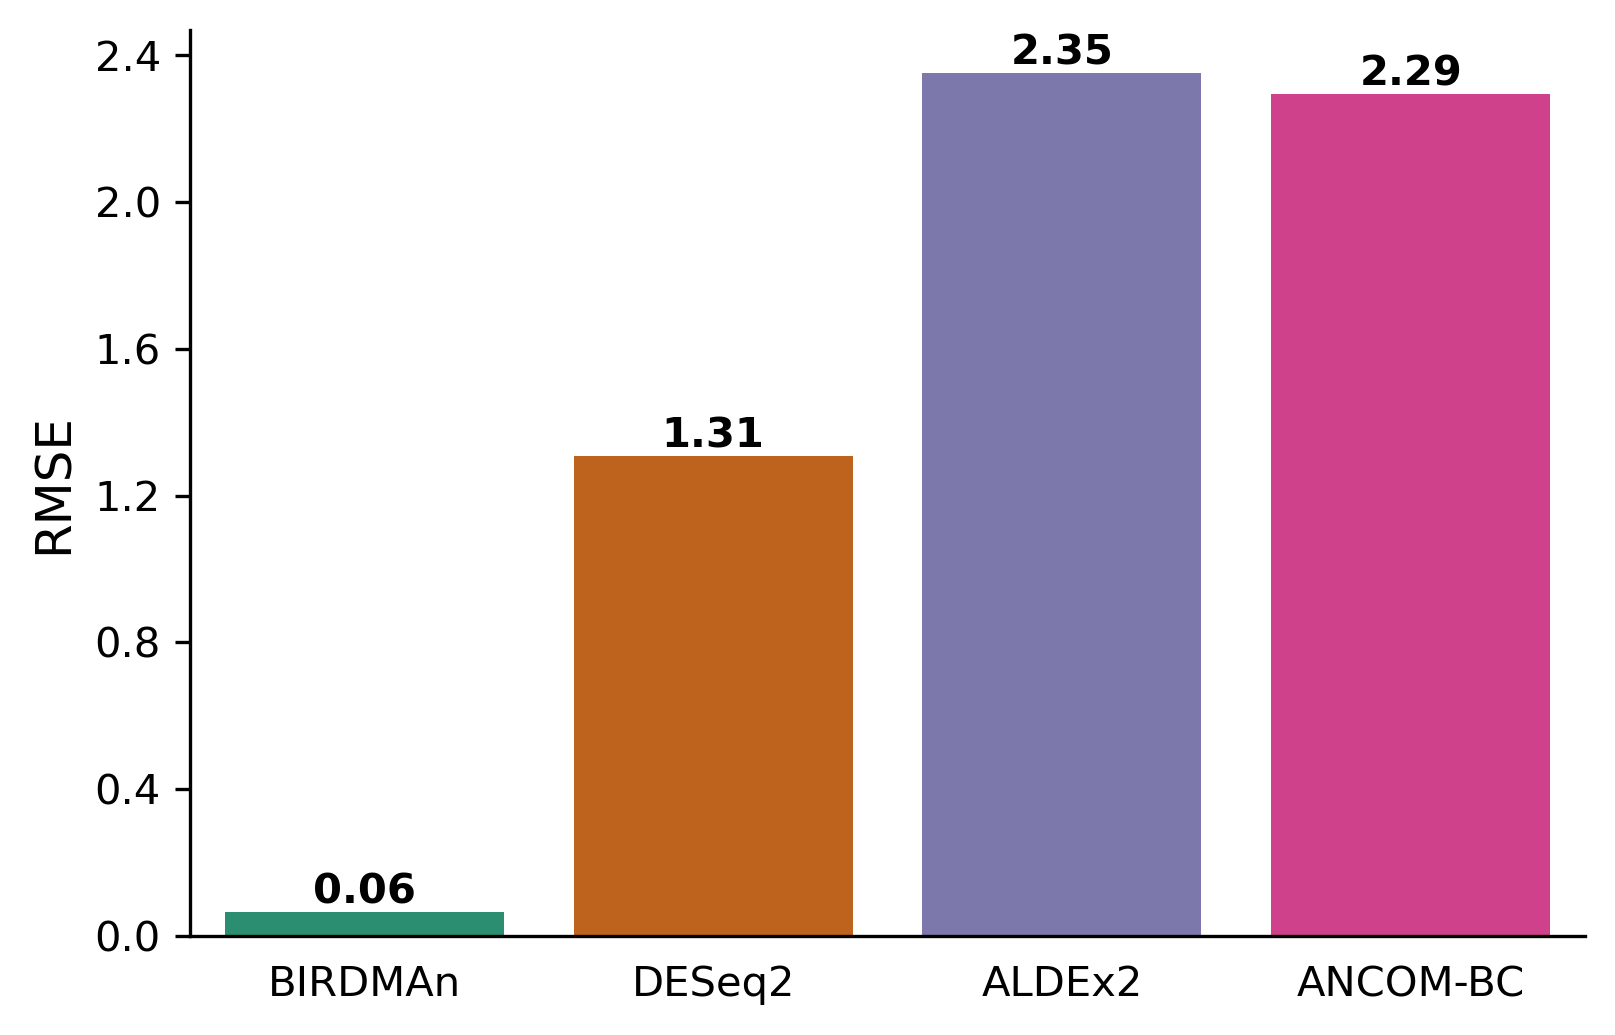

In [22]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, 1)

sns.barplot(
    data=tool_rmses,
    x="Tool",
    y="RMSE",
    palette=tool_palette,
    order=order
)
ax.tick_params("x", width=0)
ax.set_xlabel("")

for i, row in tool_rmses.iterrows():
    ax.text(
        x=i,
        y=row["RMSE"],
        s=f"{row['RMSE']:.2f}",
        va="bottom",
        ha="center",
        weight="bold"
    )

ax.yaxis.set_major_locator(MaxNLocator(8))

plt.savefig("../figures/simulation/batch_rmse.pdf")
plt.show()

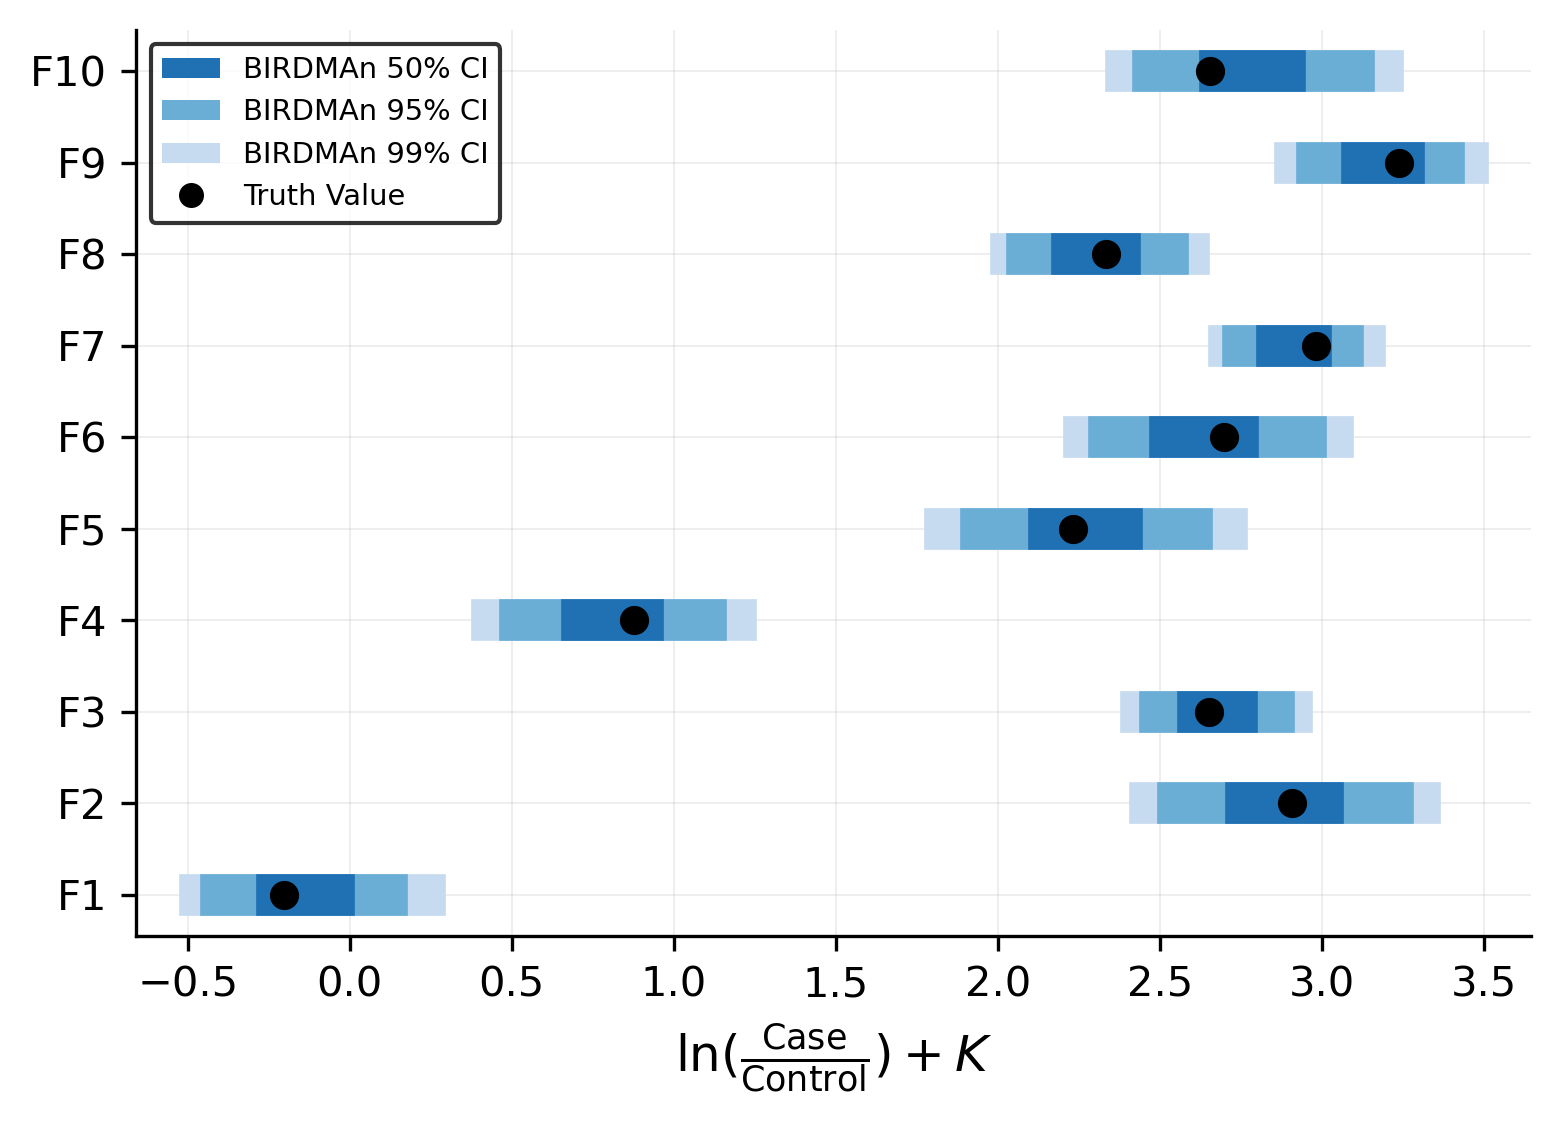

In [24]:
fig, ax = plt.subplots(1, 1)

pct_50_col = "#2070b4"
pct_95_col = "#6aaed6"
pct_99_col = "#c6dbef"

n = quantile_df.shape[1]
for i, (f, row) in enumerate(quantile_df.iterrows()):
    # plot 50%
    ax.plot(
        row.loc[[0.250, 0.750]],
        [i]*2,
        color=pct_50_col,
        lw=10,
        zorder=3
    )
    ax.plot(
        row.loc[[0.025, 0.975]],
        [i]*2,
        color=pct_95_col,
        lw=10,
        zorder=2
    )
    ax.plot(
        row.loc[[0.005, 0.995]],
        [i]*2,
        color=pct_99_col,
        lw=10,
        zorder=1
    )
    ax.scatter(
        [true_vals[f].item()],
        [i],
        zorder=4,
        color="black"
    )
    
#     for tool_name in ["ALDEx2", "ANCOM-BC", "DESeq2"]:
#         tool_col = tool_name.replace("-", "").lower() + "_beta"
#         ax.scatter(
#             [results_df.loc[f, tool_col]],
#             [i],
#             marker="s",
#             c=[tool_palette[tool_name]]
#         )

ax.set_yticks(np.arange(len(true_vals)))
ax.set_yticklabels(true_vals.index)
ax.grid()
ax.set_xlabel(r"$\ln(\frac{\mathrm{Case}}{\mathrm{Control}}) + K$")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

patch_50 = Patch(facecolor=pct_50_col, label="BIRDMAn 50% CI")
patch_95 = Patch(facecolor=pct_95_col, label="BIRDMAn 95% CI")
patch_99 = Patch(facecolor=pct_99_col, label="BIRDMAn 99% CI")
true_val_line = Line2D([0], [0], markerfacecolor="black", label="Truth Value", marker=".",
                       markeredgecolor="black", lw=0, markersize=10)

ax.legend(
    handles=[patch_50, patch_95, patch_99, true_val_line],
    edgecolor="black",
)

plt.savefig("../figures/simulation/batch_ci.pdf")
plt.show()